# House Prices: Advanced Regression Techniques - [Kaggle Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

by Hristo Dinkov

## Competition Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Practise skills:
* Creative feature engineering 
* Advanced regression techniques like random forest and gradient boosting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df_train = pd.read_csv("Documents/GitHub/Machine-Learning-AI/Machine-Learning-Projects/Kaggle-Competitions/datasets/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("Documents/GitHub/Machine-Learning-AI/Machine-Learning-Projects/Kaggle-Competitions/datasets/house-prices-advanced-regression-techniques/test.csv")

In [3]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

What we see is that we have a lot of features we need to consider. So to simplify the problem we are going to analyse it and extract the most important ones. First of all there is a data description file in the dataset, which can help us.

What I found is that the most important features are: 'OverallQuall', 'YearBuilt', 'Neighborhood', 'TotalBsmtSF' and 'GrLivArea'

## What about 'SalePrice' ?

In [4]:
df_train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

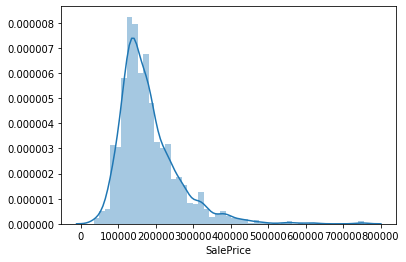

In [5]:
# Histogram
sns.distplot(df_train.SalePrice);

What we see is:
* SalePrice is not normal distributed
* Have positive skewness

In [6]:
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## Let's check if there is linearity between the chosen features and SalePrice

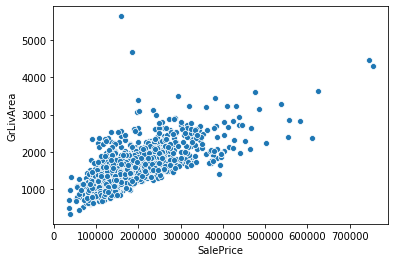

In [7]:
sns.scatterplot(df_train.SalePrice, df_train.GrLivArea);

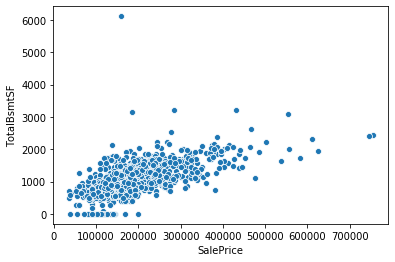

In [8]:
sns.scatterplot(df_train.SalePrice, df_train.TotalBsmtSF);

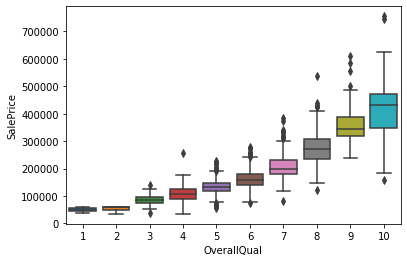

In [9]:
sns.boxplot(df_train.OverallQual, df_train.SalePrice);

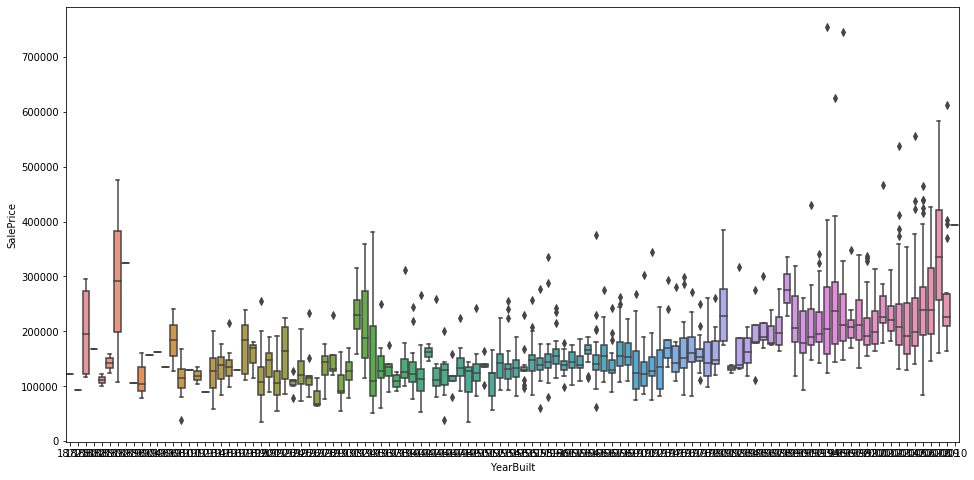

In [10]:
f, ax = plt.subplots(figsize = (16,8))
sns.boxplot(df_train.YearBuilt, df_train.SalePrice);

What we see is that:
* GrLivArea, TotalBsmtSF and OverallQual are linearly correlated with SalePrice.
* YearBuild is not as high correlated as I expexted.

## Now let's see all the correlations between all features in a correlation matrix

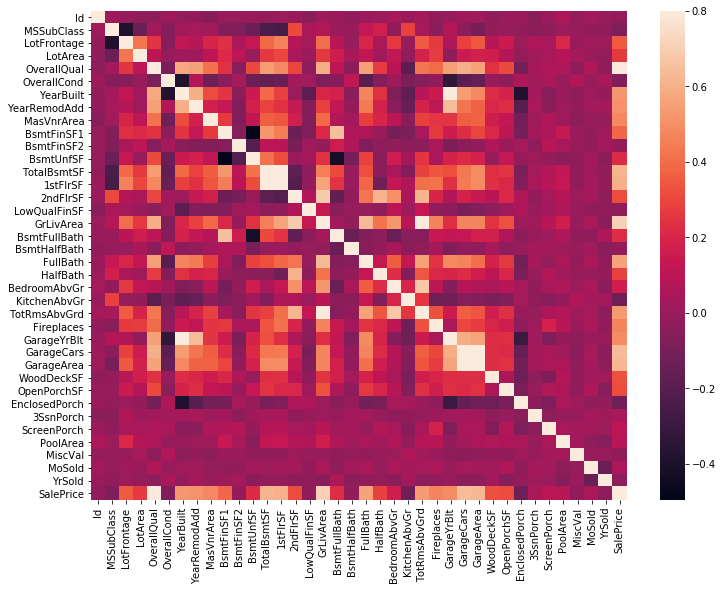

In [11]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax=.8);

Now we can see the big picture and we notice that there are a lot of uncorrelated features to SalePrice.

Now let's zoom a little bit further

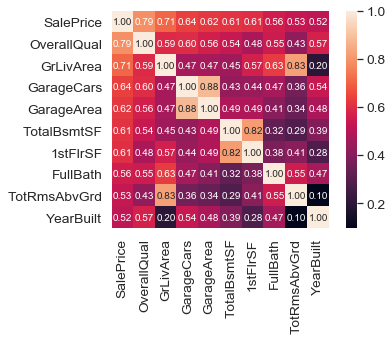

In [12]:
k = 10 # number of vars in the heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Base on the heatmap above we can extract these most correlated features and remove the features that are correlated with one another like 'TotalBsmtSF' and '1stFlrSF'

We come up with the following features:

In [13]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

## Missing data

In [14]:
#missing data
total = df_train[cols].isnull().sum().sort_values(ascending=False)
percent = (df_train[cols].isnull().sum()/df_train[cols].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
YearBuilt,0,0.0
FullBath,0,0.0
TotalBsmtSF,0,0.0
GarageCars,0,0.0
GrLivArea,0,0.0
OverallQual,0,0.0
SalePrice,0,0.0


In [15]:
# missing data on test set
if 'SalePrice' in cols:
  cols.remove('SalePrice')

total = df_test[cols].isnull().sum().sort_values(ascending=False)
percent = (df_test[cols].isnull().sum()/df_test[cols].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
TotalBsmtSF,1,0.000685
GarageCars,1,0.000685
YearBuilt,0,0.000000
FullBath,0,0.000000
GrLivArea,0,0.000000
OverallQual,0,0.000000


In [16]:
df_test.TotalBsmtSF = df_test.TotalBsmtSF.fillna(0)
df_test.GarageCars = df_test.GarageCars.fillna(0)

In [17]:
# missing data on test set
total = df_test[cols].isnull().sum().sort_values(ascending=False)
percent = (df_test[cols].isnull().sum()/df_test[cols].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
YearBuilt,0,0.0
FullBath,0,0.0
TotalBsmtSF,0,0.0
GarageCars,0,0.0
GrLivArea,0,0.0
OverallQual,0,0.0


No missing data in the columns we are interested in

## Normality 

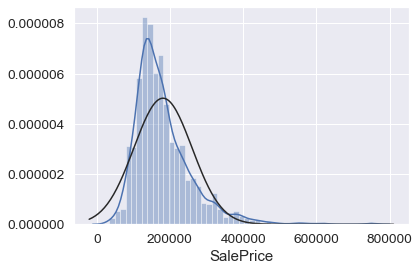

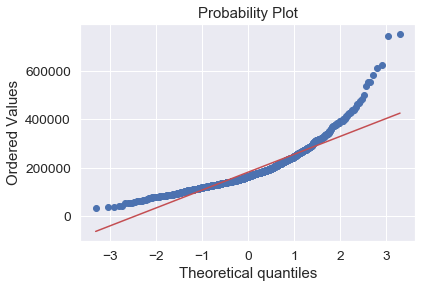

In [18]:
from scipy import stats
from scipy.stats import norm

# histogram and normal probability plot
sns.distplot(df_train.SalePrice, fit=norm);
fig = plt.figure()
res = stats.probplot(df_train.SalePrice, plot=plt)

As discussed above, 'SalePrice' is not normally distributed. We can solve this with simple log transformation.

In [19]:
df_train.SalePrice = np.log(df_train.SalePrice)

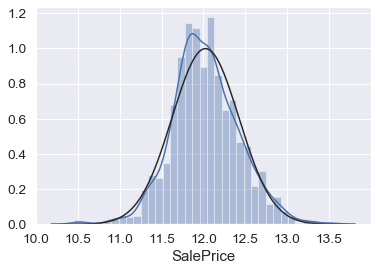

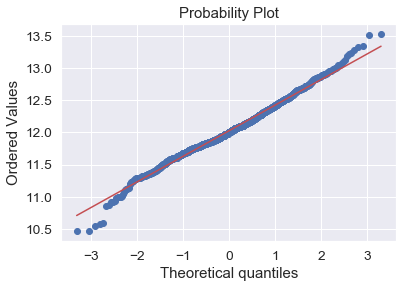

In [20]:
# histogram and normal probability plot
sns.distplot(df_train.SalePrice, fit=norm);
fig = plt.figure()
res = stats.probplot(df_train.SalePrice, plot=plt)

Now lets check GrLivArea

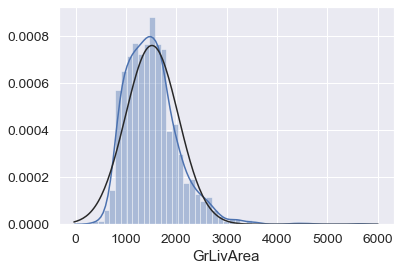

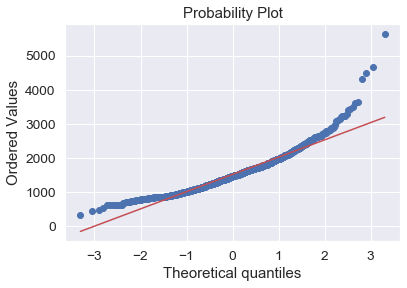

In [21]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [22]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

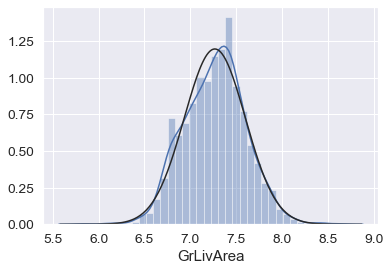

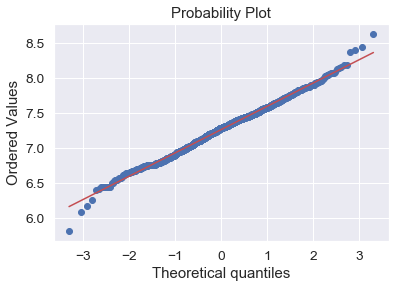

In [23]:
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

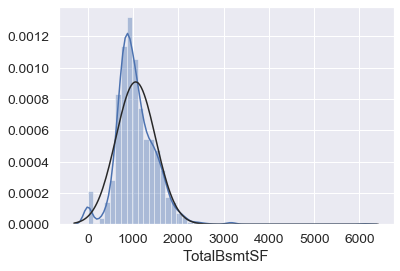

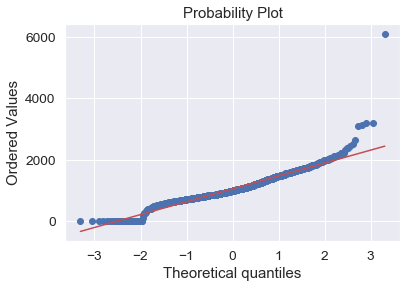

In [24]:
#histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

Here we have a lot of houses that does not have a basement, log(0) is undefined. That's why we would only apply log to houses with basements.

In [25]:
#if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

In [26]:
#transform data
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF']);

C:\Users\hryst\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


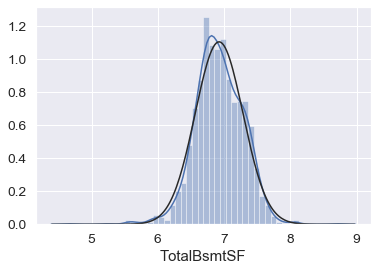

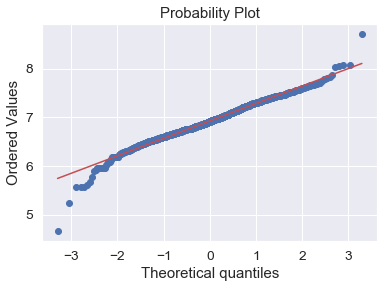

In [27]:
#histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

## Dummy variables

In [28]:
#convert categorical variable into dummy
df_train = pd.get_dummies(df_train)

In [29]:
df_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


## Scaling the data

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

if 'SalePrice' in cols:
  cols.remove('SalePrice')
X = df_train[cols]
y = df_train.SalePrice

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test[cols]

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_val = sc.transform(X_val)


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

regressor = RandomForestRegressor(n_estimators=200, random_state=0)
# regressor = SVR(kernel='rbf', degree=100, C=1, gamma=0.01, epsilon=.001)
regressor.fit(X_train, y_train)
y_pred = np.exp(regressor.predict(X_val))
y_val = np.exp(y_val)

In [32]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('RMSE/Mean (Lower is Better):', np.sqrt(metrics.mean_squared_error(y_val, y_pred)) / y_val.mean() )

Mean Absolute Error: 18932.960354163657
Mean Squared Error: 899174848.3337276
Root Mean Squared Error: 29986.244318582605
RMSE/Mean (Lower is Better): 0.16767096790674904


In [33]:
y_test_pred = np.exp(regressor.predict(X_test))

In [34]:
sub = pd.DataFrame()
sub['Id'] = df_test.Id
sub['SalePrice'] = y_test_pred

In [35]:
sub

,Id,SalePrice
0,1461,183769.956551
1,1462,204379.177889
2,1463,180543.291056
3,1464,236871.790415
4,1465,254357.931940
...,...,...
1454,2915,171742.695693
1455,2916,179401.885141
1456,2917,166042.674957
1457,2918,184115.484726


In [39]:
sub.to_csv('Documents\GitHub\Machine-Learning-AI\Machine-Learning-Projects\Kaggle-Competitions\datasets\house-prices-advanced-regression-techniques\submission.csv',index=False)